In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train_data = pd.read_excel("data/train.xlsx")
test_data = pd.read_excel("data/test.xlsx")
    
print("Первые 5 строк данных:")
print(train_data.head())
print(test_data.head())

print("\nИнформация о данных:")
print(train_data.info())
print(test_data.info())

print("\nОписательная статистика:")
print(train_data.describe())
print(test_data.describe())

print("\nПропущенные значения:")
print(train_data.isnull().sum())
print(test_data.isnull().sum())

print("\nКоличество дубликатов:")
print(train_data.duplicated().sum())
print(test_data.duplicated().sum())

Первые 5 строк данных:
          dt  Price
0 2015-01-05  32900
1 2015-01-12  32500
2 2015-01-19  32000
3 2015-01-26  30700
4 2015-02-02  30300
          dt  Price
0 2022-09-05  46000
1 2022-09-12  46000
2 2022-09-19  46000
3 2022-09-26  45500
4 2022-10-03  45500

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   dt      400 non-null    datetime64[ns]
 1   Price   400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   dt      28 non-null     datetime64[ns]
 1   Price   28 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 580.0 bytes
None

Описательная статистика:
  

In [2]:
for col in test_data.columns:
    pct_missing = np.mean(test_data[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

dt - 0%
Price - 0%


In [3]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

train_data['dt'] = pd.to_datetime(train_data['dt'])

# Извлекаем признаки из даты
train_data['year'] = train_data['dt'].dt.year
train_data['month'] = train_data['dt'].dt.month
train_data['day'] = train_data['dt'].dt.day
train_data['dayofweek'] = train_data['dt'].dt.dayofweek
train_data['week'] = train_data['dt'].dt.isocalendar().week

# Признаки (X) — все столбцы, кроме 'Price' и 'dt'
X = train_data.drop(columns=["Price", "dt"])

# Целевая переменная (y) — 'Price'
y = train_data["Price"]

# Проверка
print(X.head())  # Должны быть только признаки
print(y.head())  # Должна быть целевая переменная

# Разделение данных на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели
model = CatBoostRegressor(
    iterations=2000,  # Увеличьте количество итераций
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=10,
    verbose=100
)

# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'iterations': [500, 1000],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'depth': [4, 6, 8],
#     'l2_leaf_reg': [1, 3, 5, 10]
# }

# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
# grid_search.fit(X_train, y_train)

# print("Лучшие параметры:", grid_search.best_params_)

model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)


model.save_model("catboost_model.pkl")

   year  month  day  dayofweek  week
0  2015      1    5          0     2
1  2015      1   12          0     3
2  2015      1   19          0     4
3  2015      1   26          0     5
4  2015      2    2          0     6
0    32900
1    32500
2    32000
3    30700
4    30300
Name: Price, dtype: int64
0:	learn: 13205.4233434	test: 12384.0765298	best: 12384.0765298 (0)	total: 146ms	remaining: 4m 52s
100:	learn: 4014.8469670	test: 4884.1252129	best: 4884.1252129 (100)	total: 185ms	remaining: 3.48s
200:	learn: 3386.3796798	test: 4479.0231181	best: 4479.0231181 (200)	total: 218ms	remaining: 1.95s
300:	learn: 2874.5480220	test: 4094.0983472	best: 4093.0667589 (297)	total: 254ms	remaining: 1.43s
400:	learn: 2362.0516483	test: 3697.2358793	best: 3696.1339668 (398)	total: 292ms	remaining: 1.17s
500:	learn: 1839.7675795	test: 3271.0086487	best: 3271.0086487 (500)	total: 328ms	remaining: 983ms
600:	learn: 1483.7187773	test: 2985.8915140	best: 2985.8915140 (600)	total: 370ms	remaining: 861ms
700:

In [4]:
from catboost import CatBoostRegressor

# Загрузка модели
model = CatBoostRegressor()
model.load_model("catboost_model.pkl")

test_data['dt'] = pd.to_datetime(test_data['dt'])

# Извлекаем признаки из даты
test_data['year'] = test_data['dt'].dt.year
test_data['month'] = test_data['dt'].dt.month
test_data['day'] = test_data['dt'].dt.day
test_data['dayofweek'] = test_data['dt'].dt.dayofweek
test_data['week'] = test_data['dt'].dt.isocalendar().week

# Убираем столбец 'dt'
X_test = test_data.drop(columns=["dt"])

test_predictions = model.predict(X_test)

# Добавляем прогнозы в тестовые данные
test_data["predicted_price"] = test_predictions
print(test_data.head())

def recommend_purchase_weeks(predicted_price, current_price):
    if predicted_price > current_price:
        return 6  # Закупаем на 6 недель вперед
    else:
        return 1  # Закупаем на 1 неделю

# Предположим, что текущая цена хранится в столбце 'Price'
test_data["recommended_weeks"] = test_data.apply(
    lambda row: recommend_purchase_weeks(row["predicted_price"], row["Price"]), axis=1
)

# Сохранение результатов
test_data.to_csv("test_with_predictions.csv", index=False)

          dt  Price  year  month  day  dayofweek  week  predicted_price
0 2022-09-05  46000  2022      9    5          0    36     44904.705589
1 2022-09-12  46000  2022      9   12          0    37     40635.798960
2 2022-09-19  46000  2022      9   19          0    38     39915.509673
3 2022-09-26  45500  2022      9   26          0    39     39439.381707
4 2022-10-03  45500  2022     10    3          0    40     45185.552423


In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(X_test)

print("Длина y_pred:", len(y_pred))

X_test = test_data.drop(columns=["Price", "dt"])
y_test = test_data["Price"]


# Вычисляем метрики
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Вычисляем RMSE вручную
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")


Длина y_pred: 28
MAE: 13355.386918788437
RMSE: 15418.466011116705
R²: -17.5461944103171


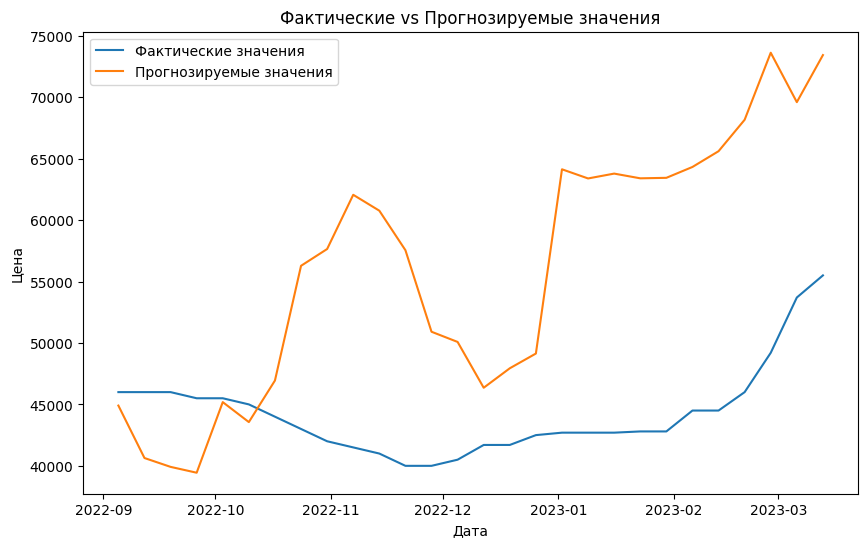

In [6]:
import matplotlib.pyplot as plt

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(test_data["dt"], y_test, label="Фактические значения")
plt.plot(test_data["dt"], y_pred, label="Прогнозируемые значения")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.title("Фактические vs Прогнозируемые значения")
plt.legend()
plt.show()

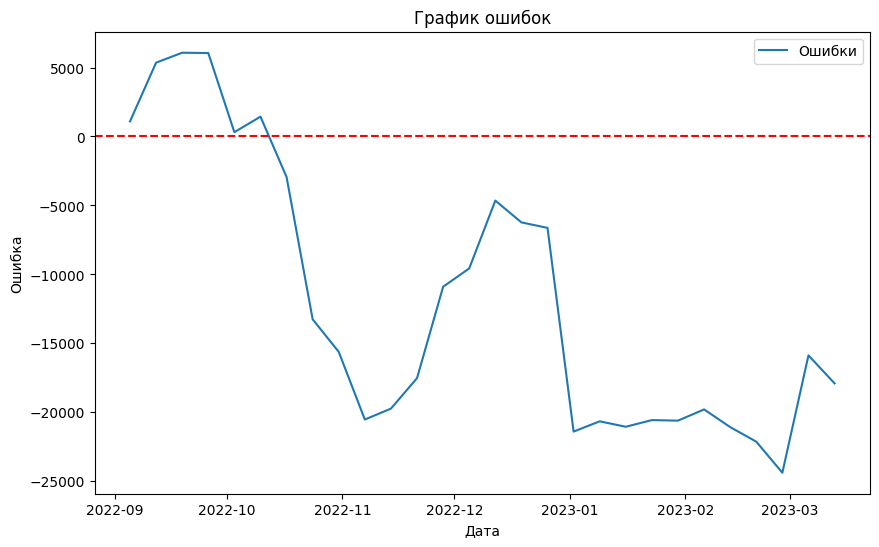

In [7]:
# Вычисляем ошибки
errors = y_test - y_pred

# Визуализация ошибок
plt.figure(figsize=(10, 6))
plt.plot(test_data["dt"], errors, label="Ошибки")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Дата")
plt.ylabel("Ошибка")
plt.title("График ошибок")
plt.legend()
plt.show()

In [8]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Кросс-валидация для временных рядов
tscv = TimeSeriesSplit(n_splits=2)
mae_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, verbose=0)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    mae_scores.append(mean_absolute_error(y_test, y_pred))

print(f"Средний MAE по кросс-валидации: {np.mean(mae_scores)}")

Средний MAE по кросс-валидации: 12798.794991459237


In [9]:
# Создаем столбец actual_price_after_N_weeks
test_data["actual_price_after_N_weeks"] = test_data["Price"].shift(-1)

# Предположим, что модель рекомендует закупить на 2 недели вперед
test_data["recommended_weeks"] = 2

# Сравниваем текущую цену с ценой через 2 недели
test_data["price_change"] = test_data["actual_price_after_N_weeks"] - test_data["Price"]

# Проверяем, была ли рекомендация правильной
test_data["recommendation_correct"] = test_data.apply(
    lambda row: (row["price_change"] > 0 and row["recommended_weeks"] > 1) or
                (row["price_change"] <= 0 and row["recommended_weeks"] == 1),
    axis=1
)

# Доля правильных рекомендаций
accuracy = test_data["recommendation_correct"].mean()
print(f"Доля правильных рекомендаций: {accuracy * 100:.2f}%")

Доля правильных рекомендаций: 35.71%
